# Text generation with an RNN

<pre>
QUEENE:
I had thought thou hadst a Roman; for the oracle,
Thus by All bids the man against the word,
Which are so weak of care, by old care done;
Your children were in your holy love,
And the precipitation through the bleeding throne.

BISHOP OF ELY:
Marry, and will, my lord, to weep in such a one were prettiest;
Yet now I was adopted heir
Of the world's lamentable day,
To watch the next way with his father with his face?

ESCALUS:
The cause why then we are all resolved more sons.

VOLUMNIA:
O, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, it is no sin it should be dead,
And love and pale as any will to that word.

QUEEN ELIZABETH:
But how long have I heard the soul for this world,
And show his hands of life be proved to stand.

PETRUCHIO:
I say he look'd on, if I must be content
To stay him from the fatal of our country's bliss.
His lordship pluck'd from this sentence then for prey,
And then let us twain, being the moon,
were she such a case as fills m
</pre>

While some of the sentences are grammatical, most do not make sense. The model has not learned the meaning of words, but consider:

* The model is character-based. When training started, the model did not know how to spell an English word, or that words were even a unit of text.

* The structure of the output resembles a play—blocks of text generally begin with a speaker name, in all capital letters similar to the dataset.

* As demonstrated below, the model is trained on small batches of text (100 characters each), and is still able to generate a longer sequence of text with coherent structure.

## Setup

### Import TensorFlow and other libraries

In [ ]:
import tensorflow as tf

import numpy as np
import os
import time

### Download the Shakespeare dataset

Change the following line to run this code on your own data.

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


## Process the text

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))

ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

seq_length = 100

sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))


# One RNN layer

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

## 20 Epochs

### Train the model




In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True))

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")


checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

history = model.fit(dataset,
                    epochs=20,
                    callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 27s 63ms/step - loss: 2.7340
Epoch 2/20
172/172 [==============================] - 12s 61ms/step - loss: 2.0002
Epoch 3/20
172/172 [==============================] - 12s 62ms/step - loss: 1.7305
Epoch 4/20
172/172 [==============================] - 13s 66ms/step - loss: 1.5683
Epoch 5/20
172/172 [==============================] - 12s 62ms/step - loss: 1.4662
Epoch 6/20
172/172 [==============================] - 12s 62ms/step - loss: 1.3964
Epoch 7/20
172/172 [==============================] - 12s 62ms/step - loss: 1.3426
Epoch 8/20
172/172 [==============================] - 12s 62ms/step - loss: 1.2976
Epoch 9/20
172/172 [==============================] - 13s 64ms/step - loss: 1.2568
Epoch 10/20
172/172 [==============================] - 13s 64ms/step - loss: 1.2181
Epoch 11/20
172/172 [==============================] - 12s 62ms/step - loss: 1.1802
Epoch 12/20
172/172 [==============================] - 13s 62ms/step - loss: 1.1400
E

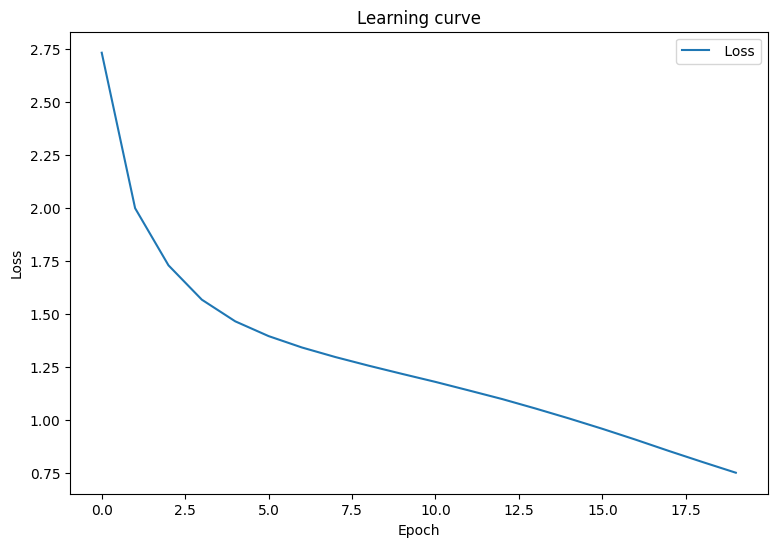

In [ ]:
# Plotting the learning curve
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
plt.plot(history.history['loss'], label=' Loss')
plt.title('Learning curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


### Generate text

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')

    input_ids = self.ids_from_chars(input_chars).to_tensor()
    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None

outlist = ['ROMEO:', 'JULIET:','HAMLET:','MACBETH:', 'OTHELLO:']

next_char = tf.constant(outlist)
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()

In [ ]:
for i,text in enumerate(result):
  print(f'----------------------- Given name - {outlist[i]}-------------------------------------- ')
  print(text.numpy().decode('utf-8'), '\n\n' + '_'*80)

#print('\nRun time:', end - start)

----------------------- Given name - ROMEO:-------------------------------------- 
ROMEO:n my tresh presence speak, sir, are it not:
Give me your wife, may stand not with the dask:
no, no more to my bolon.
Being o'er I should push on this possess'd.

BUCKINGHAM:
We can tell you, Cletto hand aptly heart: I will go along;
And now remembering holy freth, and more it me.

GLOUCESTER:
Brues greated for an asy chamber, being a time
To what we fancily inflied.

Shepard:
Sir, I think he losed this feast. Come, let's awake
There was a barbering to more strength and strange;
And see whose words reeliness.

FLORIZEL:
Here, Montague,
If thy usurping battle was the faces:
For every court-hage of a hell, sir, wrong'st, my
Lord; and my life and mine, and fruy.

TRANIO:
Sweet plant, good night! give this noble whete
Gream oppression from our brothers turnant.

CATESBY:
If it be not, then, Clifford!

CAPULET:
Although your honour had lust in my mistress'?

CATESBY:
My lord.

DUKE VINCENTIO:
What's your

## 30 Epochs

### Train the model




In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True))

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")


checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

history = model.fit(dataset,
                    epochs=30,
                    callbacks=[checkpoint_callback])

Epoch 1/30
172/172 [==============================] - 15s 65ms/step - loss: 0.6869
Epoch 2/30
172/172 [==============================] - 13s 64ms/step - loss: 0.6201
Epoch 3/30
172/172 [==============================] - 12s 62ms/step - loss: 0.5808
Epoch 4/30
172/172 [==============================] - 12s 62ms/step - loss: 0.5470
Epoch 5/30
172/172 [==============================] - 12s 62ms/step - loss: 0.5190
Epoch 6/30
172/172 [==============================] - 13s 64ms/step - loss: 0.4976
Epoch 7/30
172/172 [==============================] - 12s 62ms/step - loss: 0.4779
Epoch 8/30
172/172 [==============================] - 12s 62ms/step - loss: 0.4630
Epoch 9/30
172/172 [==============================] - 12s 62ms/step - loss: 0.4489
Epoch 10/30
172/172 [==============================] - 12s 62ms/step - loss: 0.4377
Epoch 11/30
172/172 [==============================] - 12s 62ms/step - loss: 0.4312
Epoch 12/30
172/172 [==============================] - 12s 62ms/step - loss: 0.4261
E

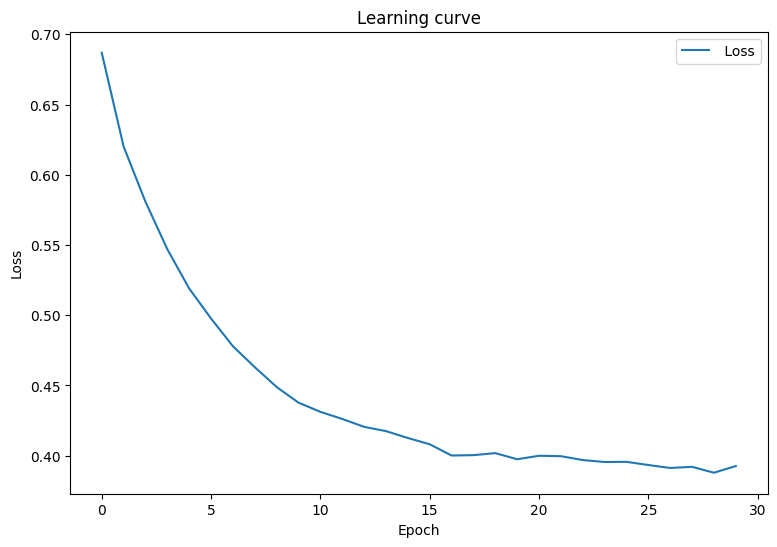

In [ ]:
# Plotting the learning curve
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
plt.plot(history.history['loss'], label=' Loss')
plt.title('Learning curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


### Generate text

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')

    input_ids = self.ids_from_chars(input_chars).to_tensor()
    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None

outlist = ['ROMEO:', 'JULIET:','HAMLET:','MACBETH:', 'OTHELLO:']

next_char = tf.constant(outlist)
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()

In [ ]:
for i,text in enumerate(result):
  print(f'----------------------- Given name - {outlist[i]}-------------------------------------- ')
  print(text.numpy().decode('utf-8'), '\n\n' + '_'*80)

#print('\nRun time:', end - start)

----------------------- Given name - ROMEO:-------------------------------------- 
ROMEO:
Than let me boys with door.

PROSPERO:
God save you, greater:
I am light for the Duke of Lancaster is deadly been
When sweet black despair nothing.

ANTIGONUS:
Look your father's be,
If he seek you that from such a handy thoughts:
What thou art poor full of willess before the king.

BUSTY:
Ah, whither shall interpetation that we frew,
And told his very hour, if you were so.

YORK:
I were not but to say the tribunes: sure, it beggar,
To men our soldier from the fearful times!'
Smiles at the feast. Luction figures days,
This day those honours have renatch'd themselves?
We will at leaves and rid her gown, but subjects'd
A vesselves, you and call mine arms.

CAMILLO:
Nay.

CLARENCE:
I know standly, sir.

AUTOLYCUS:
Verily.

AUTOLYCUS:
Here's the mistoney's of a king;
And when this are undo the bloody body
And Juliet bleeding in the sea?

KATHARINA:
Well have I love you,--

CORIOLANUS:
I know his heart

# Two RNN layer

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super(MyModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru1 = tf.keras.layers.GRU(rnn_units,
                                        return_sequences=True,
                                        return_state=True,
                                        stateful=False)  # Ensure it's not stateful by default
        self.gru2 = tf.keras.layers.GRU(rnn_units,
                                        return_sequences=True,
                                        return_state=True,
                                        stateful=False)  # Ensure it's not stateful by default
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states1=None, states2=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)

        if states1 is None:
            states1 = self.gru1.get_initial_state(x)

        x, states1 = self.gru1(x, initial_state=states1, training=training)

        if states2 is None:
            states2 = self.gru2.get_initial_state(x)

        x, states2 = self.gru2(x, initial_state=states2, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, states1, states2
        else:
            return x

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

## 20 Epochs

### Train the model




In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True))

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")


checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

history = model.fit(dataset,
                    epochs=20,
                    callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 31s 127ms/step - loss: 2.6611
Epoch 2/20
172/172 [==============================] - 24s 128ms/step - loss: 1.8318
Epoch 3/20
172/172 [==============================] - 25s 136ms/step - loss: 1.5589
Epoch 4/20
172/172 [==============================] - 26s 141ms/step - loss: 1.4342
Epoch 5/20
172/172 [==============================] - 26s 143ms/step - loss: 1.3577
Epoch 6/20
172/172 [==============================] - 27s 144ms/step - loss: 1.3018
Epoch 7/20
172/172 [==============================] - 27s 143ms/step - loss: 1.2541
Epoch 8/20
172/172 [==============================] - 26s 143ms/step - loss: 1.2092
Epoch 9/20
172/172 [==============================] - 26s 143ms/step - loss: 1.1655
Epoch 10/20
172/172 [==============================] - 27s 146ms/step - loss: 1.1186
Epoch 11/20
172/172 [==============================] - 28s 149ms/step - loss: 1.0670
Epoch 12/20
172/172 [==============================] - 26s 142ms/step - lo

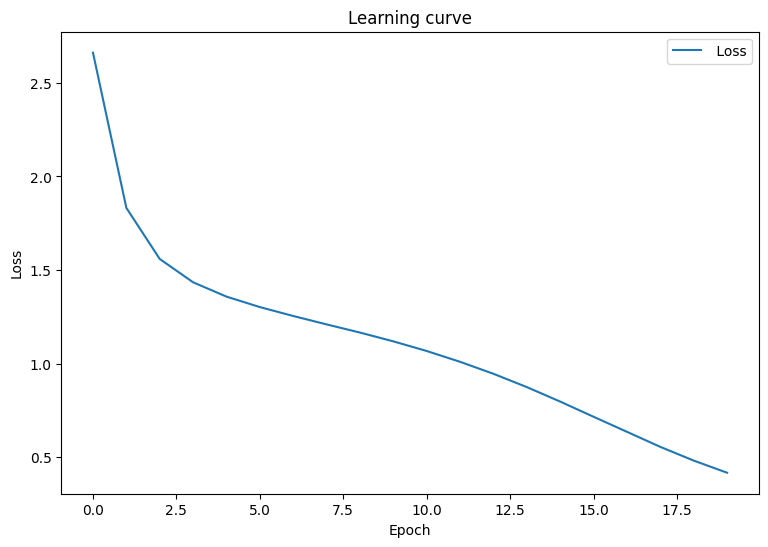

In [ ]:
# Plotting the learning curve
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
plt.plot(history.history['loss'], label=' Loss')
plt.title('Learning curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


### Generate text

In [ ]:
class OneStep(tf.keras.Model):
    def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.chars_from_ids = chars_from_ids
        self.ids_from_chars = ids_from_chars

        # Create a mask to prevent "[UNK]" from being generated.
        skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(
            # Put a -inf at each bad index.
            values=[-float('inf')]*len(skip_ids),
            indices=skip_ids,
            # Match the shape to the vocabulary
            dense_shape=[len(ids_from_chars.get_vocabulary())])
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    @tf.function
    def generate_one_step(self, inputs, states=[None, None]):

        input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
        input_ids = self.ids_from_chars(input_chars).to_tensor()
        predicted_logits, state1, state2 = self.model(inputs=input_ids, states1=states[0], states2=states[1], return_state=True)
        new_states = [state1, state2]

        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits /= self.temperature

        predicted_logits += self.prediction_mask


        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)


        predicted_chars = self.chars_from_ids(predicted_ids)

        return predicted_chars, new_states

one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()

# Initial states for each RNN layer
states = [None, None]

outlist = ['ROMEO:', 'JULIET:', 'HAMLET:', 'MACBETH:', 'OTHELLO:']
next_char = tf.constant(outlist)

result = [next_char]

for n in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

result = tf.strings.join(result)

end = time.time()

In [ ]:
for i,text in enumerate(result):
  print(f'----------------------- Given name - {outlist[i]}-------------------------------------- ')
  print(text.numpy().decode('utf-8'), '\n\n' + '_'*80)

#print('\nRun time:', end - start)

----------------------- Given name - ROMEO:-------------------------------------- 
ROMEO:
The commonwealth of your bed. You have got speeding
Can spread fully.

GLOUCESTER:
Foul weather, and say that I did mean to both,
That stabb'd me in his power i' the Capitol!

BRUTUS:
We took him well met.

SLY:
I am the whitest very growing opposed
Thbout of rancour of your offices,
But fill his own life and all in stranger:
I'll draw the firm: God with thy specite
By some report I have turn'd your love,
But bid it weak and also and drinking gett
A themable delights, wipe, I charge thee, flatt,
And leaves not this suit of law and in
Unto our soft corders' drums and tacklings?

DUKE VINCENTIO:
You were not firmless after?

ANGELO:
Yes.

advise:
An you one, Catesby.

SAMPSON:
Let have heard from men, and that reflied me,
Men give loot prosperirgh in his bowling
County Paris hath tempted Rume to have.

PROSPERO:
Go do not say 'tis show.

PROSPERO:
Coffer, what shalt thou live?

Groom:
When who shall

## 30 Epochs

### Train the model




In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True))

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")


checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

history = model.fit(dataset,
                    epochs=30,
                    callbacks=[checkpoint_callback])

Epoch 1/30
172/172 [==============================] - 27s 132ms/step - loss: 0.3540
Epoch 2/30
172/172 [==============================] - 26s 139ms/step - loss: 0.2784
Epoch 3/30
172/172 [==============================] - 26s 143ms/step - loss: 0.2488
Epoch 4/30
172/172 [==============================] - 27s 145ms/step - loss: 0.2325
Epoch 5/30
172/172 [==============================] - 27s 146ms/step - loss: 0.2294
Epoch 6/30
172/172 [==============================] - 27s 145ms/step - loss: 0.2328
Epoch 7/30
172/172 [==============================] - 26s 144ms/step - loss: 0.2321
Epoch 8/30
172/172 [==============================] - 26s 144ms/step - loss: 0.2295
Epoch 9/30
172/172 [==============================] - 27s 145ms/step - loss: 0.2197
Epoch 10/30
172/172 [==============================] - 27s 145ms/step - loss: 0.2116
Epoch 11/30
172/172 [==============================] - 26s 144ms/step - loss: 0.2066
Epoch 12/30
172/172 [==============================] - 26s 144ms/step - lo

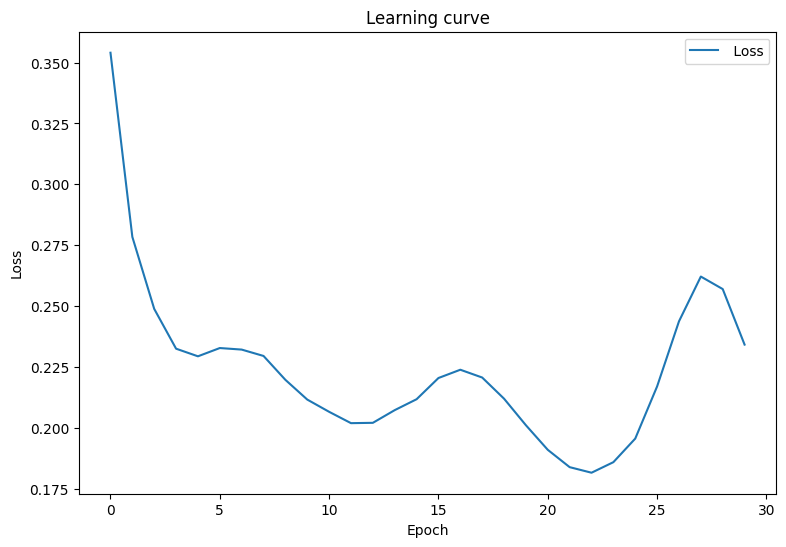

In [ ]:
# Plotting the learning curve
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
plt.plot(history.history['loss'], label=' Loss')
plt.title('Learning curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


### Generate text

In [ ]:
class OneStep(tf.keras.Model):
    def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.chars_from_ids = chars_from_ids
        self.ids_from_chars = ids_from_chars

        # Create a mask to prevent "[UNK]" from being generated.
        skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(
            # Put a -inf at each bad index.
            values=[-float('inf')]*len(skip_ids),
            indices=skip_ids,
            # Match the shape to the vocabulary
            dense_shape=[len(ids_from_chars.get_vocabulary())])
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    @tf.function
    def generate_one_step(self, inputs, states=[None, None]):

        input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
        input_ids = self.ids_from_chars(input_chars).to_tensor()
        predicted_logits, state1, state2 = self.model(inputs=input_ids, states1=states[0], states2=states[1], return_state=True)
        new_states = [state1, state2]

        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits /= self.temperature

        predicted_logits += self.prediction_mask


        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)


        predicted_chars = self.chars_from_ids(predicted_ids)

        return predicted_chars, new_states

one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()

# Initial states for each RNN layer
states = [None, None]

outlist = ['ROMEO:', 'JULIET:', 'HAMLET:', 'MACBETH:', 'OTHELLO:']
next_char = tf.constant(outlist)

result = [next_char]

for n in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

result = tf.strings.join(result)

end = time.time()

In [ ]:
for i,text in enumerate(result):
  print(f'----------------------- Given name - {outlist[i]}-------------------------------------- ')
  print(text.numpy().decode('utf-8'), '\n\n' + '_'*80)

#print('\nRun time:', end - start)

----------------------- Given name - ROMEO:-------------------------------------- 
ROMEO:
The commons was not they follow.

POMPEY:
I beseech you, you shall have the muscadel of the house:
For God's sake, talk'd with an Rutland Mine honest.

TRANIO:
Why should you gave us the body of this?
Can I do thither.

POMPEY:
Pray, say God, he that scarce consult me of those pains,
That best beseeming of an English queec,
And bid her, father, even. Farewell.

CORIOLANUS:
That's my brave boron'd at hand,
That with such vehemency he scoles mine ears
Such tidings o'er enough to be my heirs.

LEONTES:
Proceed:
Besides, you voices.

MENENIUS:
You have stood been a man,--
GRUMIO:
O, sir, the father's ground.

PERDITA:
Now Jove of such a gentleman; naw, in word,
Then I'll commend her son. Let me not know,
My dear son with such moant to be part;
We will not yield to his enemies.

PRINCE EDWARD:
Welcome, my lord, let us avoilt
In whold time, hath raised mine,
Whene'er the town is full all to be compassio

# Discussion
**Quality of Generated Text Coherence:**
Initially, the generated text might appear random or nonsensical. As the model trains and improves, you'll notice the text becoming more coherent, with sentences making more logical sense. However, achieving perfect coherence, especially over longer text spans, is challenging.
Vocabulary and Grammar: Early results often include many grammatical errors and a limited vocabulary. Over time, as the model learns from the training data, the diversity of the vocabulary increases, and grammatical accuracy improves.

**The effect of number of epochs and RNN layer**:
Increasing the number of epochs during training generally improves the coherence of text generated by RNN models because the model learns more about the structure and patterns in the training data. However, simply adding more RNN layers doesn't guarantee better results and can sometimes make the generated text appear more random. This is because deeper models are harder to train due to issues like vanishing and exploding gradients, and they may overfit to the training data, focusing on minor patterns rather than learning the underlying structure.